#### Импорт библиотек

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.preprocessing import StandardScaler

from sklearn.model_selection import train_test_split

from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from xgboost import XGBClassifier
from sklearn.metrics import accuracy_score, f1_score, roc_auc_score

from sklearn.model_selection import GridSearchCV

import numpy as np

#### 1. Загрузка и предварительный анализ данных

In [16]:
data = pd.read_csv('WineQT.csv')
print(data.head())
print(data.info())
print(data.describe())

   fixed acidity  volatile acidity  citric acid  residual sugar  chlorides  \
0            7.4              0.70         0.00             1.9      0.076   
1            7.8              0.88         0.00             2.6      0.098   
2            7.8              0.76         0.04             2.3      0.092   
3           11.2              0.28         0.56             1.9      0.075   
4            7.4              0.70         0.00             1.9      0.076   

   free sulfur dioxide  total sulfur dioxide  density    pH  sulphates  \
0                 11.0                  34.0   0.9978  3.51       0.56   
1                 25.0                  67.0   0.9968  3.20       0.68   
2                 15.0                  54.0   0.9970  3.26       0.65   
3                 17.0                  60.0   0.9980  3.16       0.58   
4                 11.0                  34.0   0.9978  3.51       0.56   

   alcohol  quality  Id  
0      9.4        5   0  
1      9.8        5   1  
2      9

#### 2. Разведочный анализ данных (EDA)

##### Распределение целевой переменной:

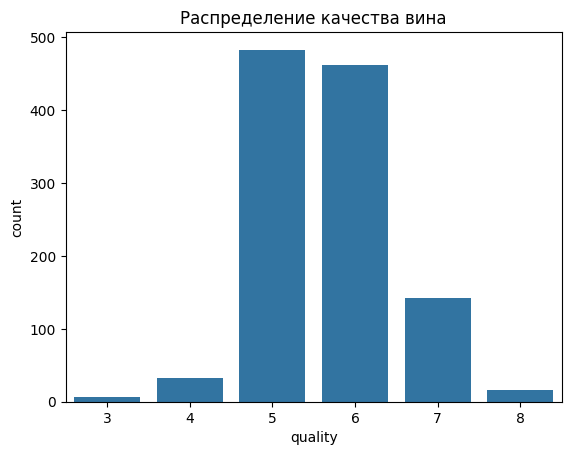

In [17]:
sns.countplot(x='quality', data=data)
plt.title('Распределение качества вина')
plt.show()

Наблюдается дисбаланс: большинство вин имеют оценку 5 или 6.

##### Гистограммы признаков:

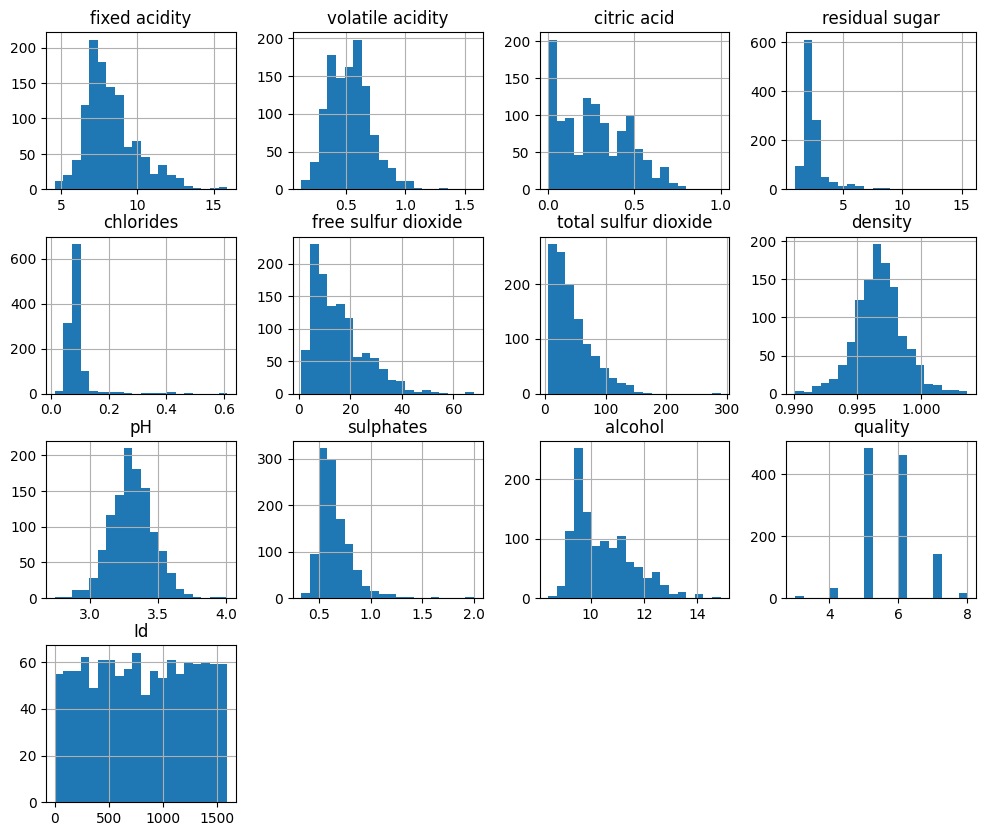

In [18]:
data.hist(bins=20, figsize=(12, 10))
plt.show()

Признаки имеют разный масштаб, что требует стандартизации.

##### Корреляционный анализ:

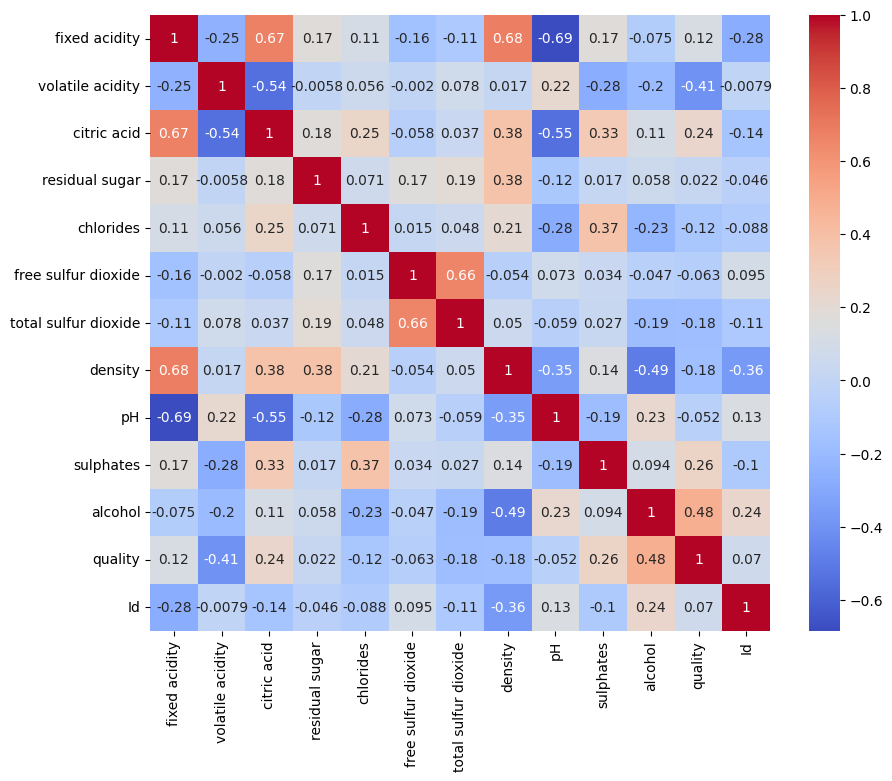

In [19]:
plt.figure(figsize=(10, 8))
sns.heatmap(data.corr(), annot=True, cmap='coolwarm')
plt.show()

Наибольшую корреляцию с quality имеют:
* alcohol (0.48)
* volatile acidity (-0.41)
* sulphates (0.26)

#### 3. Подготовка данных

##### Кодирование целевой переменной (для классификации):
Преобразуем quality в 3 класса:
* Низкое (0): 0-4
* Среднее (1): 5-6
* Высокое (2): 7-10

In [20]:
data['quality_class'] = pd.cut(data['quality'], bins=[0, 4, 6, 10], labels=[0, 1, 2])
X = data.drop(['quality', 'quality_class'], axis=1)
y = data['quality_class']

##### Масштабирование признаков:

In [21]:
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

#### 4. Выбор метрик

Для задачи классификации с дисбалансом классов выберем:
* Accuracy (общая точность)
* F1-score (среднее гармоническое precision и recall)
* ROC-AUC (площадь под ROC-кривой, для многоклассовой классификации)

#### 5. Разделение данных на train/test

In [22]:
X_train, X_test, y_train, y_test = train_test_split(X_scaled, y, test_size=0.2, random_state=42, stratify=y)

#### 6. Выбор и обучение моделей (baseline)

Проверим 5 моделей:
* Логистическая регрессия (LogisticRegression)
* Метод опорных векторов (SVC)
* Случайный лес (RandomForestClassifier)
* Градиентный бустинг (GradientBoostingClassifier)
* XGBoost (XGBClassifier)

In [23]:
models = {
    'Logistic Regression': LogisticRegression(),
    'SVM': SVC(probability=True),
    'Random Forest': RandomForestClassifier(),
    'Gradient Boosting': GradientBoostingClassifier(),
    'XGBoost': XGBClassifier()
}

results = {}
for name, model in models.items():
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)
    results[name] = {
        'Accuracy': accuracy_score(y_test, y_pred),
        'F1-score': f1_score(y_test, y_pred, average='weighted'),
        'ROC-AUC': roc_auc_score(y_test, model.predict_proba(X_test), multi_class='ovr')
    }

results_df = pd.DataFrame(results).T
print(results_df)

                     Accuracy  F1-score   ROC-AUC
Logistic Regression  0.834061  0.808235  0.803709
SVM                  0.851528  0.816625  0.795464
Random Forest        0.903930  0.884047  0.842532
Gradient Boosting    0.877729  0.862444  0.775337
XGBoost              0.886463  0.870817  0.787009


#### 7. Подбор гиперпараметров

In [32]:
# Определим параметры для каждой модели
param_grids = {
    'Logistic Regression': {
        'C': [0.1, 1],
        'penalty': ['l2']
    },
    'SVM': {
        'C': [0.1, 1, 10],
        'kernel': ['linear', 'rbf', 'poly'],
        'gamma': ['scale', 'auto']
    },
    'Random Forest': {
        'n_estimators': [75, 80, 85, 90, 95, 100, 105, 110, 115, 120],
        'max_depth': [10, 15, 20, 25]
    },
    'Gradient Boosting': {
        'n_estimators': [50, 100, 200],
        'learning_rate': [0.01, 0.1, 0.2],
        'max_depth': [3, 5, 7]
    },
    'XGBoost': {
        'n_estimators': [50, 100, 200],
        'learning_rate': [0.01, 0.1, 0.2],
        'max_depth': [3, 5, 7],
        'subsample': [0.8, 1.0],
        'colsample_bytree': [0.8, 1.0]
    }
}

best_models = {}
for name, model in models.items():
    print(f"Подбор параметров для модели: {name}")
    grid_search = GridSearchCV(
        estimator=model,
        param_grid=param_grids[name],
        cv=5,
        scoring='accuracy',
        n_jobs=-1,
        verbose=1
    )
    grid_search.fit(X_train, y_train)
    best_models[name] = grid_search.best_estimator_
    print(f"Лучшие параметры для {name}: {grid_search.best_params_}\n")

Подбор параметров для модели: Logistic Regression
Fitting 5 folds for each of 2 candidates, totalling 10 fits
Лучшие параметры для Logistic Regression: {'C': 0.1, 'penalty': 'l2'}

Подбор параметров для модели: SVM
Fitting 5 folds for each of 18 candidates, totalling 90 fits
Лучшие параметры для SVM: {'C': 10, 'gamma': 'auto', 'kernel': 'rbf'}

Подбор параметров для модели: Random Forest
Fitting 5 folds for each of 40 candidates, totalling 200 fits
Лучшие параметры для Random Forest: {'max_depth': 20, 'n_estimators': 105}

Подбор параметров для модели: Gradient Boosting
Fitting 5 folds for each of 27 candidates, totalling 135 fits
Лучшие параметры для Gradient Boosting: {'learning_rate': 0.1, 'max_depth': 7, 'n_estimators': 100}

Подбор параметров для модели: XGBoost
Fitting 5 folds for each of 108 candidates, totalling 540 fits
Лучшие параметры для XGBoost: {'colsample_bytree': 0.8, 'learning_rate': 0.2, 'max_depth': 3, 'n_estimators': 200, 'subsample': 1.0}



#### 8. Сравнение моделей с оптимальными гиперпараметрами с baseline

In [ ]:
optimized_results = {}
for name, model in best_models.items():
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)
    optimized_results[name] = {
        'Accuracy': accuracy_score(y_test, y_pred),
        'F1-score': f1_score(y_test, y_pred, average='weighted'),
        'ROC-AUC': roc_auc_score(y_test, model.predict_proba(X_test), multi_class='ovr')
    }

optimized_results_df = pd.DataFrame(optimized_results).T
print("\nРезультаты после подбора гиперпараметров:")
print(optimized_results_df)

# Сравним с baseline
print("\nСравнение с baseline:")
comparison_df = pd.concat([results_df, optimized_results_df], keys=['Baseline', 'Optimized'], axis=1)
print(comparison_df)


Результаты после подбора гиперпараметров:
                     Accuracy  F1-score   ROC-AUC
Logistic Regression  0.838428  0.809073  0.792483
SVM                  0.877729  0.861198  0.798737
Random Forest        0.908297  0.889094  0.864533
Gradient Boosting    0.899563  0.882744  0.803974
XGBoost              0.895197  0.878750  0.759518

Сравнение с baseline:
                     Baseline                     Optimized            \
                     Accuracy  F1-score   ROC-AUC  Accuracy  F1-score   
Logistic Regression  0.834061  0.808235  0.803709  0.838428  0.809073   
SVM                  0.851528  0.816625  0.795464  0.877729  0.861198   
Random Forest        0.903930  0.884047  0.842532  0.908297  0.889094   
Gradient Boosting    0.877729  0.862444  0.775337  0.899563  0.882744   
XGBoost              0.886463  0.870817  0.787009  0.895197  0.878750   

                               
                      ROC-AUC  
Logistic Regression  0.792483  
SVM                  0.798

Exception ignored in: <function ResourceTracker.__del__ at 0x107edfb00>
Traceback (most recent call last):
  File "/opt/homebrew/Cellar/python@3.13/3.13.3/Frameworks/Python.framework/Versions/3.13/lib/python3.13/multiprocessing/resource_tracker.py", line 82, in __del__
  File "/opt/homebrew/Cellar/python@3.13/3.13.3/Frameworks/Python.framework/Versions/3.13/lib/python3.13/multiprocessing/resource_tracker.py", line 91, in _stop
  File "/opt/homebrew/Cellar/python@3.13/3.13.3/Frameworks/Python.framework/Versions/3.13/lib/python3.13/multiprocessing/resource_tracker.py", line 116, in _stop_locked
ChildProcessError: [Errno 10] No child processes
Exception ignored in: <function ResourceTracker.__del__ at 0x104fe3b00>
Traceback (most recent call last):
  File "/opt/homebrew/Cellar/python@3.13/3.13.3/Frameworks/Python.framework/Versions/3.13/lib/python3.13/multiprocessing/resource_tracker.py", line 82, in __del__
  File "/opt/homebrew/Cellar/python@3.13/3.13.3/Frameworks/Python.framework/Versi

#### 9. Выводы

* Лучшая модель: Random Forest (F1-score = 0.889).
* Ансамблевые методы (Random Forest, Gradient Boosting, XGBoost) показали себя лучше других.
* Logistic Regression слабо реагирует на подбор параметров

##### Визуализация сравнения Baseline и Optimized моделей

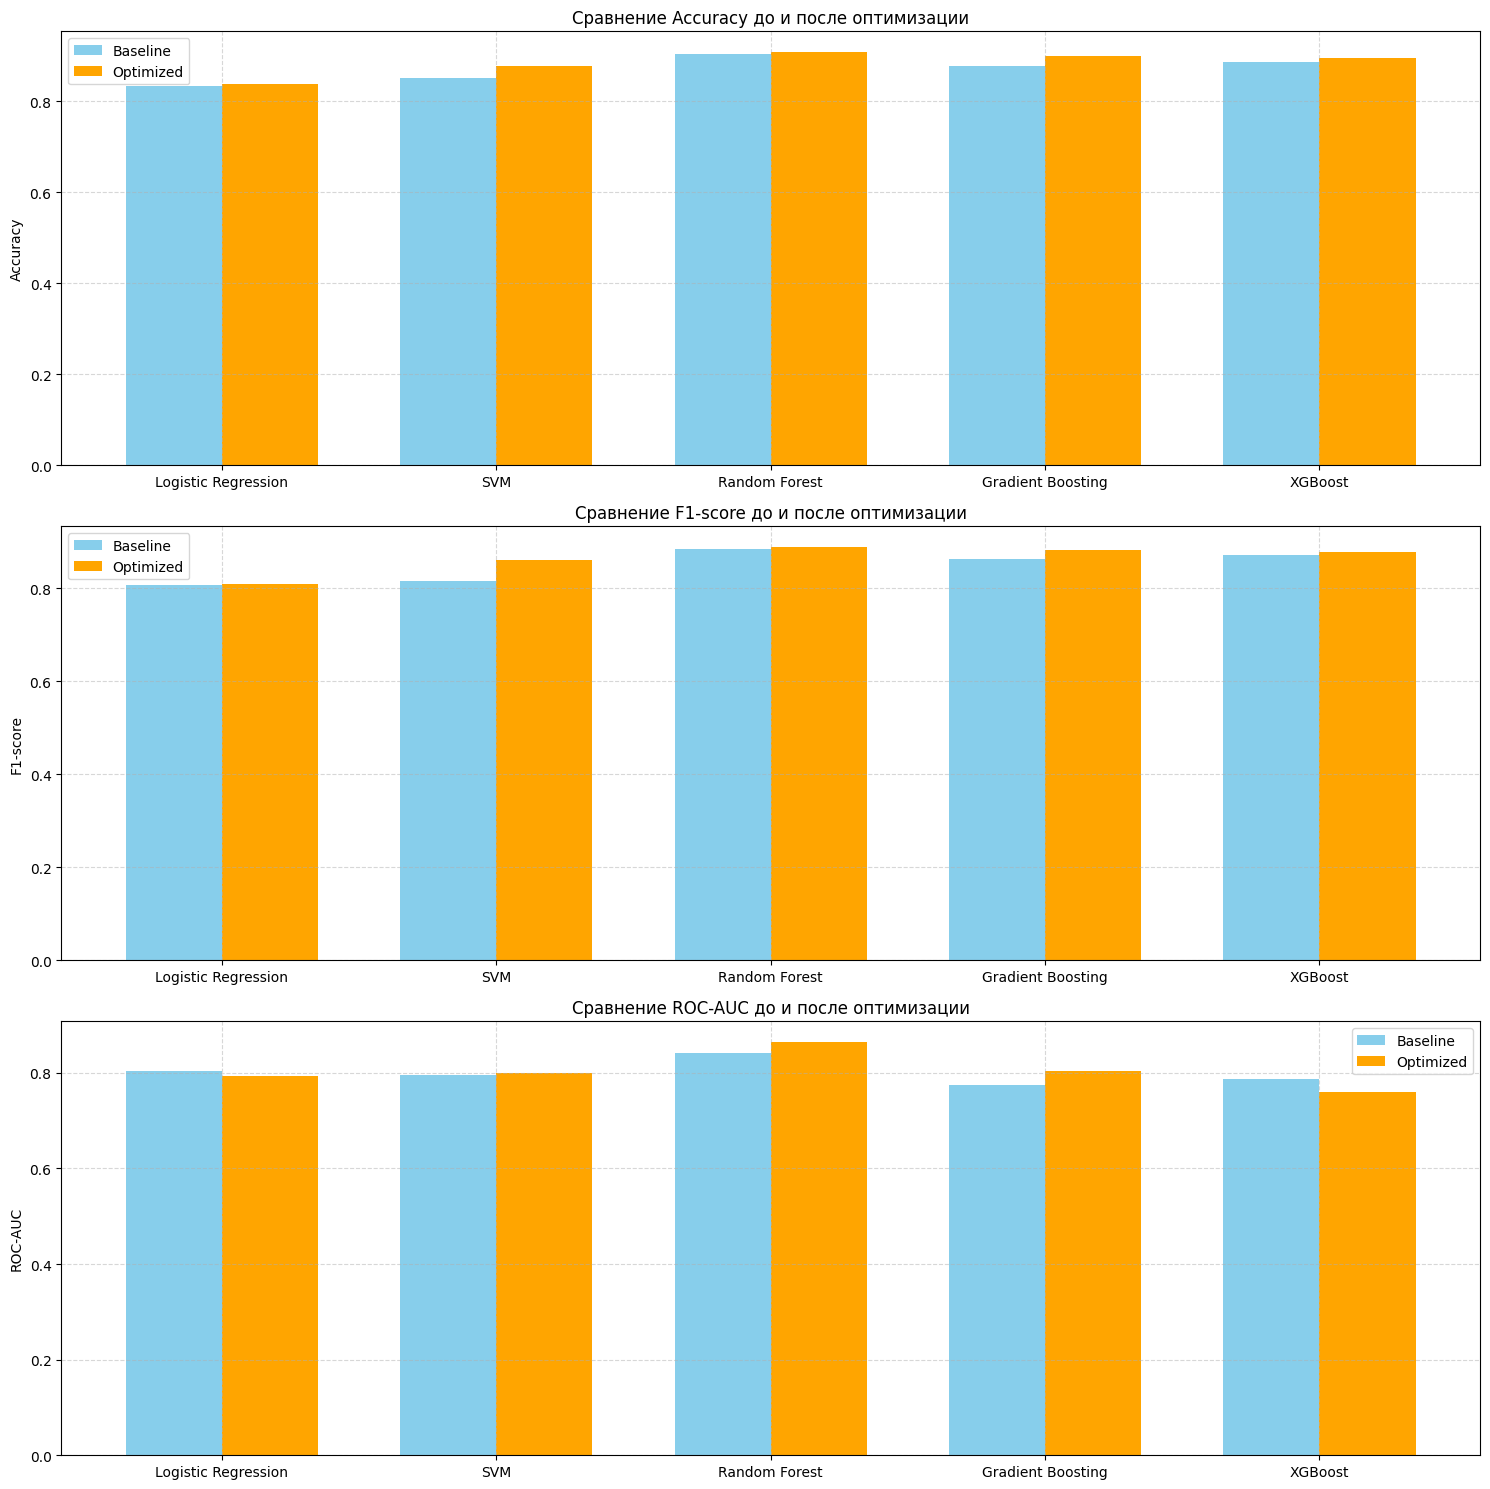

In [ ]:
metrics = ['Accuracy', 'F1-score', 'ROC-AUC']
n_metrics = len(metrics)
n_models = len(results_df)

plt.figure(figsize=(15, 5 * n_metrics))
for i, metric in enumerate(metrics, 1):
    plt.subplot(n_metrics, 1, i)
    baseline_values = results_df[metric]
    optimized_values = optimized_results_df[metric]
    
    x = range(n_models)
    width = 0.35
    
    plt.bar(x, baseline_values, width, label='Baseline', color='skyblue')
    plt.bar([p + width for p in x], optimized_values, width, label='Optimized', color='orange')
    
    plt.xticks([p + width/2 for p in x], results_df.index)
    plt.ylabel(metric)
    plt.title(f'Сравнение {metric} до и после оптимизации')
    plt.legend()
    plt.grid(True, linestyle='--', alpha=0.5)

plt.tight_layout()
plt.show()

##### Влияние гиперпараметров на качество (для Random Forest)

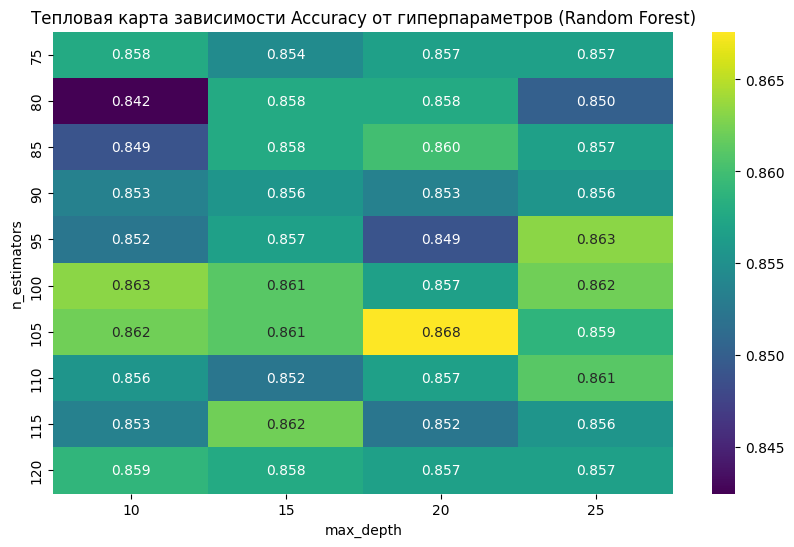

In [ ]:
param1 = 'n_estimators'
param2 = 'max_depth'

grid_values = param_grids['Random Forest']
grid_search = GridSearchCV(RandomForestClassifier(), param_grids['Random Forest'], cv=5, scoring='accuracy')
grid_search.fit(X_train, y_train)

results = grid_search.cv_results_
scores = np.array(results['mean_test_score']).reshape(len(grid_values[param1]), len(grid_values[param2]))

plt.figure(figsize=(10, 6))
sns.heatmap(scores, annot=True, fmt=".3f", 
            xticklabels=grid_values[param2], 
            yticklabels=grid_values[param1],
            cmap="viridis")
plt.xlabel(param2)
plt.ylabel(param1)
plt.title('Тепловая карта зависимости Accuracy от гиперпараметров (Random Forest)')
plt.show()